In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

sns.set_style("white")
sns.set_context('notebook')

Using TensorFlow backend.


In [2]:
training_data = pd.read_pickle('../data/training_data.pkl')

In [4]:
training_data.groupby('call').size()

call
a    13745
f     1600
g     3946
s    17781
dtype: int64

In [5]:
# Get Labels
Y = pd.get_dummies(training_data.call).astype(float).values
# Get training data as numpy array
X = training_data.drop('call', axis=1).astype(float).values

In [6]:
X.shape

(37072, 67)

In [7]:
Y.shape

(37072, 4)

In [3]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [9]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(67, input_dim=67, kernel_initializer='normal', activation='relu'))
    model.add(Dense(23, activation='relu'))
    model.add(Dense(23, activation='relu'))
    model.add(Dense(4, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [10]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=10, batch_size=5, verbose=1)

In [11]:
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [12]:
probabilities = cross_val_predict(estimator, X, Y, cv=kfold, method='predict_proba')

Epoch 1/10
33364/33364 [==============================] - 30s - loss: 0.7363 - acc: 0.6868    
Epoch 2/10
33364/33364 [==============================] - 23s - loss: 0.6110 - acc: 0.7531    
Epoch 3/10
33364/33364 [==============================] - 26s - loss: 0.5786 - acc: 0.7664    
Epoch 4/10
33364/33364 [==============================] - 25s - loss: 0.5632 - acc: 0.7729    
Epoch 5/10
33364/33364 [==============================] - 26s - loss: 0.5509 - acc: 0.7778    
Epoch 6/10
33364/33364 [==============================] - 25s - loss: 0.5420 - acc: 0.7827    
Epoch 7/10
33364/33364 [==============================] - 25s - loss: 0.5326 - acc: 0.7850    
Epoch 8/10
33364/33364 [==============================] - 25s - loss: 0.5274 - acc: 0.7857    
Epoch 9/10
33364/33364 [==============================] - 25s - loss: 0.5219 - acc: 0.7900    
Epoch 10/10
33364/33364 [==============================] - 26s - loss: 0.7351 - acc: 0.6891    
Epoch 2/10
33364/33364 [=========================

33365/33365 [==============================] - 29s - loss: 0.6133 - acc: 0.7524    
Epoch 3/10
33365/33365 [==============================] - 29s - loss: 0.5796 - acc: 0.7663    
Epoch 4/10
33365/33365 [==============================] - 29s - loss: 0.5621 - acc: 0.7710    
Epoch 5/10
33365/33365 [==============================] - 29s - loss: 0.5500 - acc: 0.7760    
Epoch 6/10
33365/33365 [==============================] - 29s - loss: 0.5386 - acc: 0.7809    
Epoch 7/10
33365/33365 [==============================] - 29s - loss: 0.5328 - acc: 0.7841    
Epoch 8/10
33365/33365 [==============================] - 29s - loss: 0.5264 - acc: 0.7871    
Epoch 9/10
33365/33365 [==============================] - 29s - loss: 0.5206 - acc: 0.7893    
Epoch 10/10
33365/33365 [==============================] - 30s - loss: 0.7278 - acc: 0.6936    
Epoch 2/10
33365/33365 [==============================] - 29s - loss: 0.6103 - acc: 0.7547    
Epoch 3/10
33365/33365 [==============================] - 29

In [13]:
predicted = np.array([list(a).index(max(list(a))) for a in list(probabilities)])

In [14]:
label_binarizer = preprocessing.LabelBinarizer()

label_binarizer.fit(range(max(predicted)+1))
predicted_transformed = label_binarizer.transform(predicted)

In [15]:
metrics.accuracy_score(Y, predicted_transformed)

0.7869551143720328

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = germline
* 3 = somatic

In [16]:
print(metrics.classification_report(Y, predicted_transformed))

             precision    recall  f1-score   support

          0       0.79      0.74      0.77     13745
          1       0.56      0.48      0.51      1600
          2       0.59      0.80      0.68      3946
          3       0.86      0.84      0.85     17781

avg / total       0.79      0.79      0.79     37072



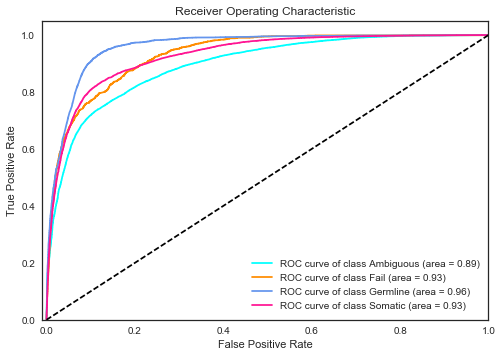

In [17]:
n_classes = Y.shape[1]
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Germline', 3: 'Somatic'}
fpr = dict()
tpr = dict()
roc_auc = dict()
plt.title('Receiver Operating Characteristic')
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink'])
for i, color in zip(range(n_classes), colors):
    fpr[i], tpr[i], _ = metrics.roc_curve(Y[:, i], probabilities[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, label='ROC curve of class {0}'
             ' (area = {1:0.2f})'.format(class_lookup[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [18]:
%matplotlib inline

In [24]:
prob_df = pd.DataFrame(probabilities, columns=['Ambiguous','Fail',
                                               'Germline', 'Somatic'])

# Normalize the values by dividing each value by the sum of its columns
prob_df_norm = prob_df.div(prob_df.sum(axis=1), axis=0)

label_index = pd.DataFrame(Y, columns=['Ambiguous','Fail',
                                          'Germline','Somatic'], dtype=bool)

positive_probabilities = prob_df_norm[label_index].unstack().dropna().values

positive_counts, bins = np.histogram(positive_probabilities, bins=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])

negative_probabilities = prob_df_norm[~label_index].unstack().dropna()

negative_counts, _ = np.histogram(negative_probabilities, bins=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])

pct_positive = positive_counts / (positive_counts + negative_counts)

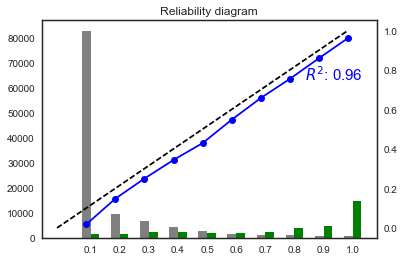

In [26]:
width = 0.03       # the width of the bars

fig, ax1 = plt.subplots()
rects1 = ax1.bar(bins[1:], negative_counts, width, color='grey')

rects2 = ax1.bar(bins[1:] + width, positive_counts, width, color='green')

# add some text for labels, title and axes ticks

ax1.set_title('Reliability diagram')
ax1.set_xticks(bins[1:] + width / 2)
ax1.set_xticklabels(bins[1:])
# ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

# ax1.legend((rects1[0], rects2[0]), ('Neg', 'Pos'), loc=5)

ax2 = ax1.twinx()
ax2.plot([0, 1], [0, 1], 'k--')
r2 = metrics.r2_score(bins[1:], pct_positive)
ax2.plot(bins[1:], pct_positive, "-o", color='blue')
ax2.text(.85,.75,'$R^2$: {0:0.2f}'.format(r2), color='blue', fontsize=15)


plt.show()

## Refactor to single class classifier 
Manual reviewer's calling variants germline is problematic as the callers that produced the calls are designed to call somatic variants. These germline calls are likely very poor quality and in most analysis streams get thrown out anyway. While 'ambigous' variant exist in a grey area where the reviewer is unsure whether to call the variant somatic or fail. All of these classes (germile, ambiguous, and fail) are treated the same in downstream analysis (thrown out).

In [4]:
training_data.groupby('call').size()

call
a    13745
f     1600
g     3946
s    17781
dtype: int64

In [5]:
training_data['binary_call'] = training_data.call.replace(['a', 'f', 'g'], False)
training_data['binary_call'] = training_data['binary_call'].replace('s', True)

In [6]:
training_data.groupby('binary_call').size()

binary_call
False    19291
True     17781
dtype: int64

In [7]:
# Get Labels
binary_Y = training_data.binary_call.astype(int).values
# Get training data as numpy array
X = training_data.drop(['call', 'binary_call'], axis=1).astype(float).values

In [8]:
X.shape

(37072, 67)

In [9]:
binary_Y.shape

(37072,)

In [14]:
# define baseline model
def baseline_binary_model():
    # create model
    model = Sequential()
    model.add(Dense(67, input_dim=67, kernel_initializer='normal', activation='relu'))
    model.add(Dense(23, activation='relu'))
    model.add(Dense(23, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [15]:
binary_estimator = KerasClassifier(build_fn=baseline_binary_model, epochs=10, batch_size=5, verbose=1)

In [16]:
binary_kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [17]:
binary_probabilities = cross_val_predict(binary_estimator, X, binary_Y, cv=binary_kfold, method='predict_proba')

Epoch 1/10
33364/33364 [==============================] - 32s - loss: 0.4274 - acc: 0.8141    
Epoch 2/10
33364/33364 [==============================] - 32s - loss: 0.3720 - acc: 0.8439    
Epoch 3/10
33364/33364 [==============================] - 30s - loss: 0.3545 - acc: 0.8514    
Epoch 4/10
33364/33364 [==============================] - 29s - loss: 0.3450 - acc: 0.8563    
Epoch 5/10
33364/33364 [==============================] - 29s - loss: 0.3397 - acc: 0.8576    
Epoch 6/10
33364/33364 [==============================] - 29s - loss: 0.3330 - acc: 0.8615    
Epoch 7/10
33364/33364 [==============================] - 30s - loss: 0.3291 - acc: 0.8631    
Epoch 8/10
33364/33364 [==============================] - 34s - loss: 0.3252 - acc: 0.8633    
Epoch 9/10
33364/33364 [==============================] - 35s - loss: 0.3219 - acc: 0.8652    
Epoch 10/10
33364/33364 [==============================] - 35s - loss: 0.4352 - acc: 0.8105    
Epoch 2/10
33364/33364 [=========================

33365/33365 [==============================] - 38s - loss: 0.3795 - acc: 0.8404    
Epoch 3/10
33365/33365 [==============================] - 40s - loss: 0.3606 - acc: 0.8495    
Epoch 4/10
33365/33365 [==============================] - 39s - loss: 0.3494 - acc: 0.8559    
Epoch 5/10
33365/33365 [==============================] - 38s - loss: 0.3427 - acc: 0.8589    
Epoch 6/10
33365/33365 [==============================] - 37s - loss: 0.3373 - acc: 0.8599    
Epoch 7/10
33365/33365 [==============================] - 38s - loss: 0.3323 - acc: 0.8612    
Epoch 8/10
33365/33365 [==============================] - 38s - loss: 0.3293 - acc: 0.8635    
Epoch 9/10
33365/33365 [==============================] - 36s - loss: 0.3241 - acc: 0.8653    
Epoch 10/10
33365/33365 [==============================] - 35s - loss: 0.4343 - acc: 0.8081    
Epoch 2/10
33365/33365 [==============================] - 35s - loss: 0.3776 - acc: 0.8406    
Epoch 3/10
33365/33365 [==============================] - 34

In [18]:
predicted = np.array([list(a).index(max(list(a))) for a in list(binary_probabilities)])

In [19]:
metrics.accuracy_score(binary_Y, predicted)

0.86205222270176951

In [20]:
print(metrics.classification_report(binary_Y, predicted))

             precision    recall  f1-score   support

          0       0.85      0.90      0.87     19291
          1       0.88      0.82      0.85     17781

avg / total       0.86      0.86      0.86     37072



In [21]:
somatic_prob = binary_probabilities[:,1]

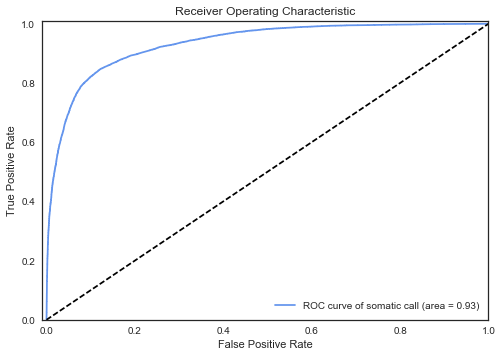

In [27]:
plt.title('Receiver Operating Characteristic')
fpr, tpr, _ = metrics.roc_curve(binary_Y, somatic_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='cornflowerblue',label='ROC curve of somatic call'
         ' (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [23]:
prob_df = pd.DataFrame(binary_probabilities, columns=['Fail', 'Somatic'])

label_index = pd.DataFrame(pd.DataFrame(np.array([np.logical_not(binary_Y),binary_Y]), dtype=bool).transpose())
label_index.columns=['Fail', 'Somatic']
positive_probabilities = prob_df[label_index].unstack().dropna().values

positive_counts, bins = np.histogram(positive_probabilities, bins=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])

negative_probabilities = prob_df[~label_index].unstack().dropna()

negative_counts, _ = np.histogram(negative_probabilities, bins=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])

pct_positive = positive_counts / (positive_counts + negative_counts)

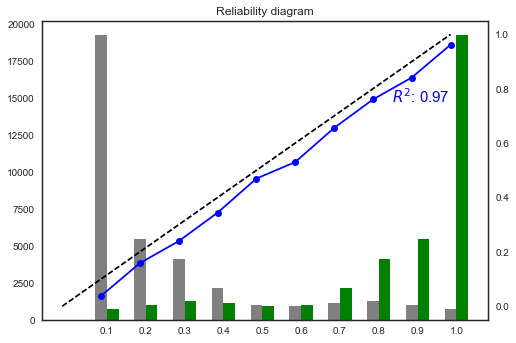

In [24]:
width = 0.03       # the width of the bars

fig, ax1 = plt.subplots()
rects1 = ax1.bar(bins[1:], negative_counts, width, color='grey')

rects2 = ax1.bar(bins[1:] + width, positive_counts, width, color='green')

# add some text for labels, title and axes ticks

ax1.set_title('Reliability diagram')
ax1.set_xticks(bins[1:] + width / 2)
ax1.set_xticklabels(bins[1:])
# ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

# ax1.legend((rects1[0], rects2[0]), ('Neg', 'Pos'), loc=5)

ax2 = ax1.twinx()
ax2.plot([0, 1], [0, 1], 'k--')
r2 = metrics.r2_score(bins[1:], pct_positive)
ax2.plot(bins[1:], pct_positive, "-o", color='blue')
ax2.text(.85,.75,'$R^2$: {0:0.2f}'.format(r2), color='blue', fontsize=15)


plt.show()

In [28]:
pct_positive

array([ 0.03785379,  0.15867615,  0.23945755,  0.34419738,  0.46961895,
        0.53038105,  0.65580262,  0.76054245,  0.84132385,  0.96214621])